# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [10]:
# Define transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform= transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform= transform)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I have applied two transformation, `ToTensor()`and `Normalization` to the orginal dataset because of the following reasons:
- ToTensor() will help us to convert PIL (Python Image Library) format to PyTorch tensor format, this will allow us to easily manipulate the images as tensors and feed them into a neural network for the next training or inference phase.
- The `normalization` can help us to normalize the data with the mean and standard deviation of the MNIST dataset, this can help us training neural networks more effectively and efficiently. 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Train dataset without normalization
2


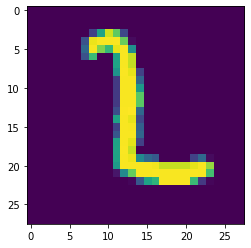

3


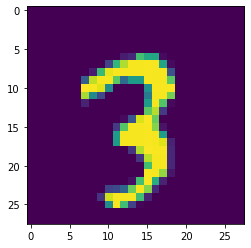

9


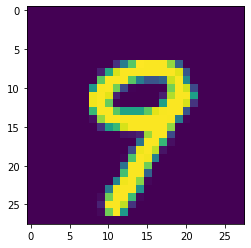

9


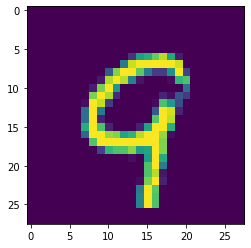

9


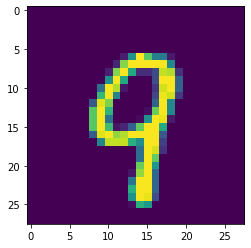

Train dataset with normalization
7


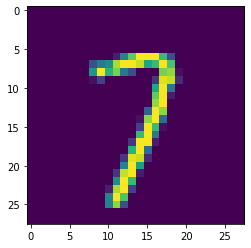

2


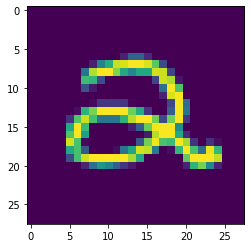

5


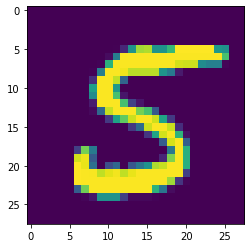

3


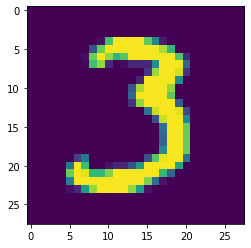

4


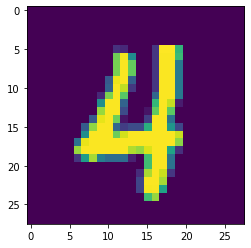

In [25]:
# Explore data
# Visualizing the training dataset with and without normalization 
print("Train dataset without normalization")
transform2 = transforms.Compose([transforms.ToTensor()])
# Create training set and define training dataloader
train_data2 = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform= transform2)
train_dataloader2 = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
show5(train_dataloader2)
print("Train dataset with normalization")
show5(train_dataloader)

In [26]:
# Explore the shape and size of the data before and after transformation 
#Before the normalization is applied 
#Get the first image 
image, label = next(iter(train_data2))
# size of the image
print("The size of the image before normalization is applied", image.size())

#After normalization is applied
image, label = next(iter(train_data))
# size of the image
print("The size of the image after normalization is ", image.size())


The size of the image before normalization is applied torch.Size([1, 28, 28])
The size of the image after normalization is  torch.Size([1, 28, 28])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [ ]:
## YOUR CODE HERE ##

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [ ]:
## YOUR CODE HERE ##

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:
## YOUR CODE HERE ##

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
## YOUR CODE HERE ##

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##